# Description
This notebook compares the results of training a Conditional Normalizing Flow model on the synthetic two moons data. The data have rotation and moon class as conditioning variables.

The comparison is between a base flow with no regularization at all and adding in Clipped Adam and Batchnormalization.

Lots of different hyperparamters are tested to see if we can get batch normalization to work

# Base loads

In [0]:
!pip install pyro-ppl==1.3.0

     |████████████████████████████████| 501kB 2.8MB/s 


In [0]:
!nvidia-smi

Tue May  5 18:07:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# "Standard" imports
import numpy as np
from time import time
import itertools
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
import folium
import datetime

# Pytorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

# Pyro imports
import pyro
from pyro.distributions import ConditionalTransformedDistribution, ConditionalTransformModule, TransformModule
import pyro.distributions as dist
from pyro.distributions.transforms import affine_coupling, affine_autoregressive, permute

# Sklearn imports
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Notebooks imports
from IPython.display import Image, display, clear_output
from tqdm import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual


import numpy as np
import folium
from folium import plugins
import matplotlib
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Mount my drive
from google.colab import drive
import sys
import os
drive.mount('/content/drive/')
root_path = 'drive/My Drive/Colab_Notebooks/normalizingflows'
trained_flows_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/trained_flows'
dataset_folder = 'drive/My Drive/Colab_Notebooks/normalizingflows/datasets'
sys.path.append(root_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


## Load Git code

In [0]:
%cd drive/'My Drive'/Thesis/code/DEwNF/
!git pull
%cd /content/

/content/drive/My Drive/Thesis/code/DEwNF
Already up to date.
/content


In [0]:
git_folder_path = 'drive/My Drive/Thesis/code/DEwNF/'
sys.path.append(git_folder_path)

In [0]:
from DEwNF.flows import ConditionalAffineCoupling, ConditionedAffineCoupling, ConditionalNormalizingFlowWrapper, conditional_affine_coupling, normalizing_flow_factory, conditional_normalizing_flow_factory
from DEwNF.utils import plot_4_contexts_cond_flow, plot_loss, sliding_plot_loss, plot_samples
from DEwNF.samplers import RotatingTwoMoonsConditionalSampler
from DEwNF.regularizers import NoiseRegularizer, rule_of_thumb_noise_schedule, approx_rule_of_thumb_noise_schedule, square_root_noise_schedule, constant_regularization_schedule


# Create Results plot for unregularized comparisons.
## We do different plots for different batch sizes


### 500 batchsize

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full1")

results_dict = {}

folders = os.listdir(base_path)
for run_name in folders:
    run_path = folder = os.path.join(base_path, run_name)
    reg_names = os.listdir(run_path)
    results_dict[run_name] = {}
    for reg_name in reg_names:
        reg_path = os.path.join(run_path, reg_name)
        file_names = os.listdir(reg_path)
        results_dict[run_name][reg_name] = {}
        for file_name in file_names:
            data_size = int(file_name.split('_')[-1].split('.')[0])
            file = os.path.join(reg_path, file_name)
            with open(file, 'rb') as f:
                loaded_dict = pickle.load(f)
            results_dict[run_name][reg_name][data_size] = loaded_dict['logs']['test'][-1]

runs = list(results_dict.keys())
#runs = ['unreg_comparison_full1', 'unreg_comparison_full2']
regs = list(results_dict[runs[0]].keys())
#regs = ['sqrt', 'l2', 'constant', 'rot']
data_sizes = np.sort(list(results_dict[runs[0]][regs[0]].keys()))

plot_arrays = {}
for reg in regs:
    reg_mean_array = []
    reg_std_array = []
    plot_arrays[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_std_array.append(np.std(runs_array))
    plot_arrays[reg]['mean'] = reg_mean_array
    plot_arrays[reg]['std'] = reg_std_array

plt.figure(figsize=(15,10))
plt.ylim(-200, 100)
#regs = ['batchnorm_and_clipped_adam']
#regs = ['base_flow']
#regs = ['batchnorm']
#regs = ['clipped_adam']
for reg in regs:
    mean = -np.array(plot_arrays[reg]['mean'])
    std = np.array(plot_arrays[reg]['std'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, mean + std, mean - std, alpha=0.1)

plt.xscale('log')
plt.legend(regs, loc='upper left', fontsize=15, markerscale=4)
plt.title('1500 epochs and 500 batchsize ', fontsize=15)
plt.xlabel('Number of datapoints', fontsize=15)
plt.ylabel('Log Likelihood')
plt.show();

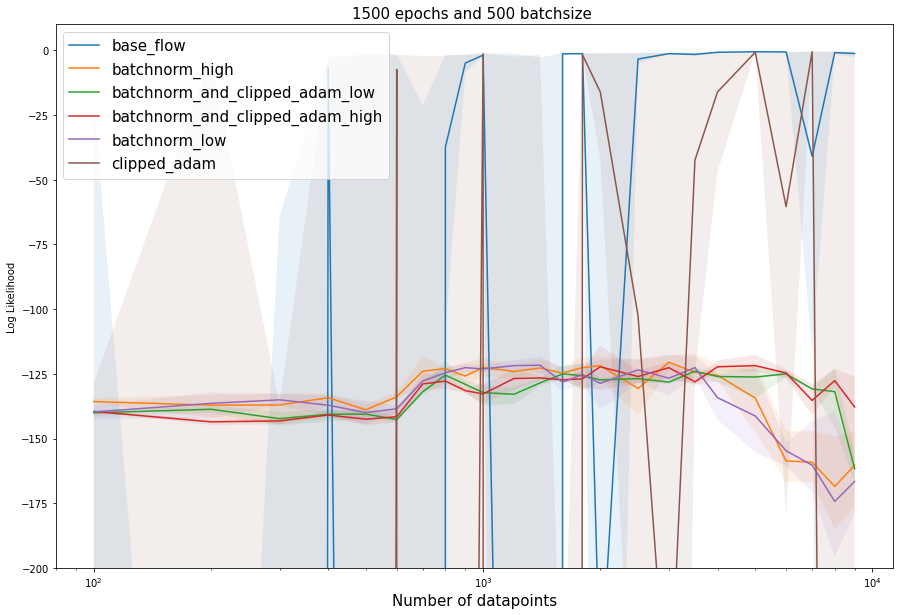

In [0]:
plot_arrays = {}
for reg in regs:
    reg_mean_array = []
    reg_max_array = []
    reg_min_array = []
    plot_arrays[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_max_array.append(np.max(runs_array))
        reg_min_array.append(np.min(runs_array))
    plot_arrays[reg]['mean'] = reg_mean_array
    plot_arrays[reg]['max'] = reg_max_array
    plot_arrays[reg]['min'] = reg_min_array


plt.figure(figsize=(15,10))
plt.ylim(-200, 10)
#regs = ['batchnorm_and_clipped_adam']
#regs = ['base_flow']
#regs = ['batchnorm']
#regs = ['clipped_adam']
for reg in regs:
    mean = -np.array(plot_arrays[reg]['mean'])
    max_val = -np.array(plot_arrays[reg]['max'])
    min_val = -np.array(plot_arrays[reg]['min'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, max_val, min_val, alpha=0.1)

plt.xscale('log')
plt.legend(regs, loc='upper left', fontsize=15, markerscale=4)
plt.title('1500 epochs and 500 batchsize ', fontsize=15)
plt.xlabel('Number of datapoints', fontsize=15)
plt.ylabel('Log Likelihood')
plt.show();

So the difference between the base flow and the flow with clipped adam is not very big. Both of these flows are unstable, especially for small data set sizes. The base flow seems to be a bit better for larger dataset sizes but this could just be by change as the plot is only the mean over 3 runs.

The flows with added in batchnorm all seems more stable. The low high after their name indicates whether the momentum of the batch norm was low or high. However the performance of these flows seems to be much worse. The flows with clipped adam seems to be performing slightly better for large datasets.

If we look at the train log of the flows with batchnorm it actually seems like these flows become even more unstable than the flows without batchnorm - which the difference in performance between batchnorm flows with and without clipped adam also might indicate(?)

### 2000 batchsize 

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full2_high_bs")

results_dict = {}

folders = os.listdir(base_path)
for run_name in folders:
    run_path = folder = os.path.join(base_path, run_name)
    reg_names = os.listdir(run_path)
    results_dict[run_name] = {}
    for reg_name in reg_names:
        reg_path = os.path.join(run_path, reg_name)
        file_names = os.listdir(reg_path)
        results_dict[run_name][reg_name] = {}
        for file_name in file_names:
            data_size = int(file_name.split('_')[-1].split('.')[0])
            file = os.path.join(reg_path, file_name)
            with open(file, 'rb') as f:
                loaded_dict = pickle.load(f)
            results_dict[run_name][reg_name][data_size] = loaded_dict['logs']['test'][-1]

runs = list(results_dict.keys())
regs = list(results_dict[runs[0]].keys())
data_sizes = np.sort(list(results_dict[runs[0]][regs[0]].keys()))

plot_arrays = {}
for reg in regs:
    reg_mean_array = []
    reg_std_array = []
    plot_arrays[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_std_array.append(np.std(runs_array))
    plot_arrays[reg]['mean'] = reg_mean_array
    plot_arrays[reg]['std'] = reg_std_array

plt.figure(figsize=(15,10))
plt.ylim(-200, 100)
for reg in regs:
    mean = -np.array(plot_arrays[reg]['mean'])
    std = np.array(plot_arrays[reg]['std'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, mean + std, mean - std, alpha=0.1)

plt.xscale('log')
plt.legend(regs, loc='upper left', fontsize=15, markerscale=4)
plt.title('1500 epochs and 2000 batchsize ', fontsize=15)
plt.xlabel('Number of datapoints', fontsize=15)
plt.ylabel('Log Likelihood')
plt.show();




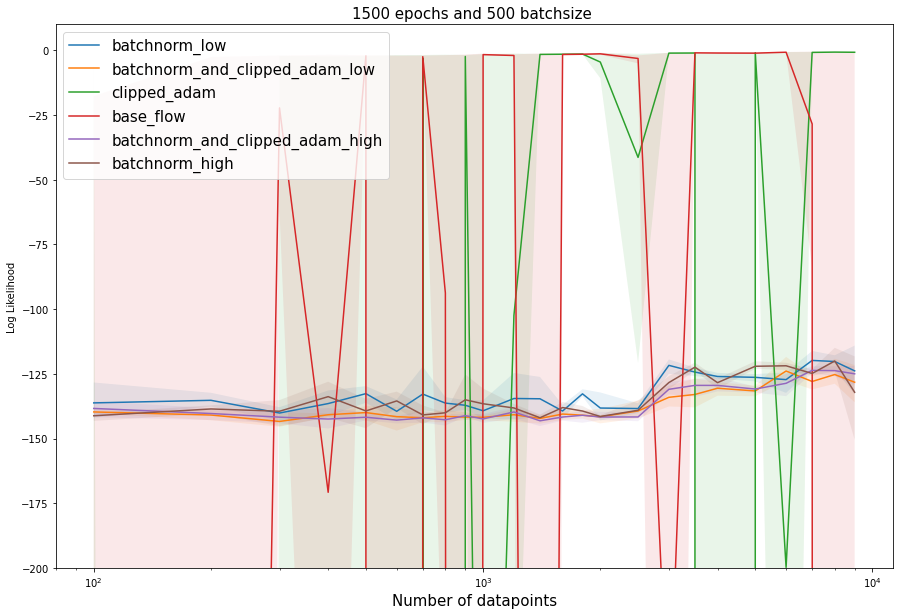

In [0]:
plot_arrays = {}
for reg in regs:
    reg_mean_array = []
    reg_max_array = []
    reg_min_array = []
    plot_arrays[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_max_array.append(np.max(runs_array))
        reg_min_array.append(np.min(runs_array))
    plot_arrays[reg]['mean'] = reg_mean_array
    plot_arrays[reg]['max'] = reg_max_array
    plot_arrays[reg]['min'] = reg_min_array


plt.figure(figsize=(15,10))
plt.ylim(-200, 10)
#regs = ['batchnorm_and_clipped_adam']
#regs = ['base_flow']
#regs = ['batchnorm']
#regs = ['clipped_adam']
for reg in regs:
    mean = -np.array(plot_arrays[reg]['mean'])
    max_val = -np.array(plot_arrays[reg]['max'])
    min_val = -np.array(plot_arrays[reg]['min'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, max_val, min_val, alpha=0.1)

plt.xscale('log')
plt.legend(regs, loc='upper left', fontsize=15, markerscale=4)
plt.title('1500 epochs and 500 batchsize ', fontsize=15)
plt.xlabel('Number of datapoints', fontsize=15)
plt.ylabel('Log Likelihood')
plt.show();

Here we have the same plot but for a larger batchsize of 2000. It's pretty much the same story but the difference between the batchnorm and batchnorm + clipped_adam flows is gone.

Also the flows without batchnorm are more unstable this time around but again it is still only based on 3 runs - experience have shown that it varies greatly from run to run (which is also one reason we want regularization)

## Batchnorm comparisons

Here we have a comparison of only the batchnorms

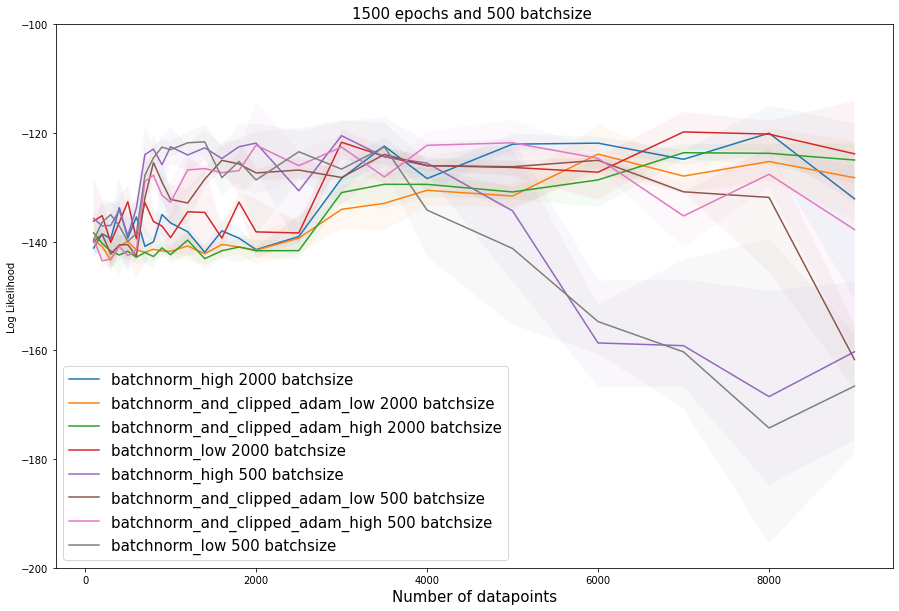

In [0]:
base_path_high = os.path.join(root_path, "results/two_moons/unreg_run_full2_high_bs")
base_path_med = os.path.join(root_path, "results/two_moons/unreg_run_full1")

results_dict_high = {}
folders = os.listdir(base_path_high)
for run_name in folders:
    run_path = folder = os.path.join(base_path_high, run_name)
    reg_names = os.listdir(run_path)
    results_dict_high[run_name] = {}
    for reg_name in reg_names:
        reg_path = os.path.join(run_path, reg_name)
        file_names = os.listdir(reg_path)
        results_dict_high[run_name][reg_name] = {}
        for file_name in file_names:
            data_size = int(file_name.split('_')[-1].split('.')[0])
            file = os.path.join(reg_path, file_name)
            with open(file, 'rb') as f:
                loaded_dict = pickle.load(f)
            results_dict_high[run_name][reg_name][data_size] = loaded_dict['logs']['test'][-1]

            
results_dict_med = {}
folders = os.listdir(base_path_med)
for run_name in folders:
    run_path = folder = os.path.join(base_path_med, run_name)
    reg_names = os.listdir(run_path)
    results_dict_med[run_name] = {}
    for reg_name in reg_names:
        reg_path = os.path.join(run_path, reg_name)
        file_names = os.listdir(reg_path)
        results_dict_med[run_name][reg_name] = {}
        for file_name in file_names:
            data_size = int(file_name.split('_')[-1].split('.')[0])
            file = os.path.join(reg_path, file_name)
            with open(file, 'rb') as f:
                loaded_dict = pickle.load(f)
            results_dict_med[run_name][reg_name][data_size] = loaded_dict['logs']['test'][-1]

runs = list(results_dict.keys())
regs =  ['batchnorm_high', 'batchnorm_and_clipped_adam_low', 'batchnorm_and_clipped_adam_high', 'batchnorm_low']
data_sizes = np.sort(list(results_dict[runs[0]][regs[0]].keys()))
            
plot_arrays_high = {}
for reg in regs:
    reg_mean_array = []
    reg_max_array = []
    reg_min_array = []
    plot_arrays_high[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict_high[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_max_array.append(np.max(runs_array))
        reg_min_array.append(np.min(runs_array))
    plot_arrays_high[reg]['mean'] = reg_mean_array
    plot_arrays_high[reg]['max'] = reg_max_array
    plot_arrays_high[reg]['min'] = reg_min_array

plot_arrays_med = {}
for reg in regs:
    reg_mean_array = []
    reg_max_array = []
    reg_min_array = []
    plot_arrays_med[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict_med[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_max_array.append(np.max(runs_array))
        reg_min_array.append(np.min(runs_array))
    plot_arrays_med[reg]['mean'] = reg_mean_array
    plot_arrays_med[reg]['max'] = reg_max_array
    plot_arrays_med[reg]['min'] = reg_min_array


plt.figure(figsize=(15,10))
plt.ylim(-200, -100)
legend_arr = []

for reg in regs:
    mean = -np.array(plot_arrays_high[reg]['mean'])
    max_val = -np.array(plot_arrays_high[reg]['max'])
    min_val = -np.array(plot_arrays_high[reg]['min'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, max_val, min_val, alpha=0.05)
    legend_arr.append(f"{reg} 2000 batchsize")

for reg in regs:
    mean = -np.array(plot_arrays_med[reg]['mean'])
    max_val = -np.array(plot_arrays_med[reg]['max'])
    min_val = -np.array(plot_arrays_med[reg]['min'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, max_val, min_val, alpha=0.05)
    legend_arr.append(f"{reg} 500 batchsize")
    

#plt.xscale('log')
plt.legend(legend_arr, loc='lower left', fontsize=15, markerscale=4)
plt.title('1500 epochs and 500 batchsize ', fontsize=15)
plt.xlabel('Number of datapoints', fontsize=15)
plt.ylabel('Log Likelihood')
plt.show();




Only comparing the batchnorm flows we can see that all of the flows performs simillarly (bad). However the 500 batch size seems to be slightly worse unless it has both batchnorm and clipped adam.

# Test single model

Here we just take a quick look at the training logs of different flows.

## 500 batchsize

### Small dataset size

In [0]:
data_size = 1000

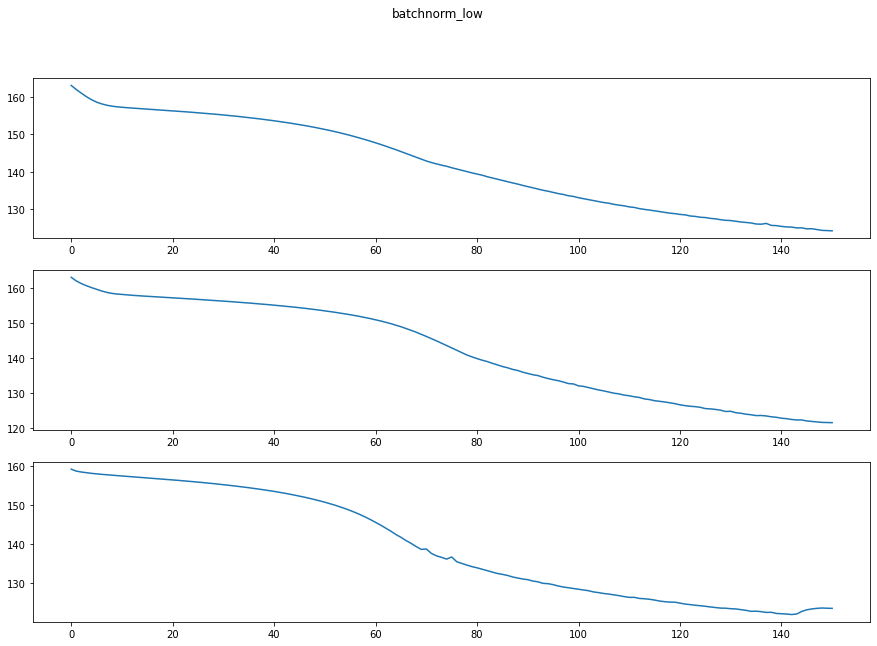

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full1")
flow_type = 'batchnorm_low'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/{flow_type}_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

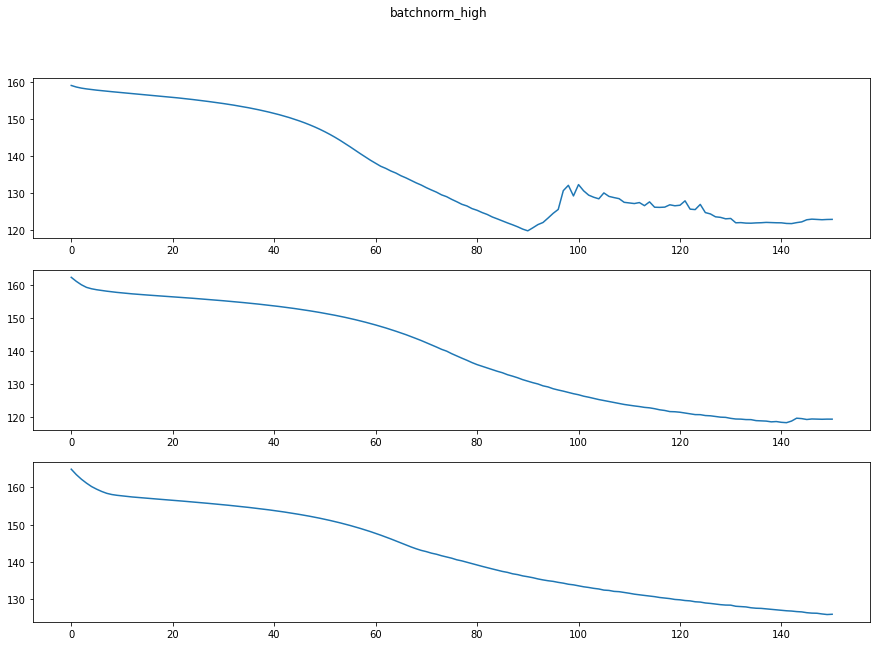

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full1")
flow_type = 'batchnorm_high'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/{flow_type}_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

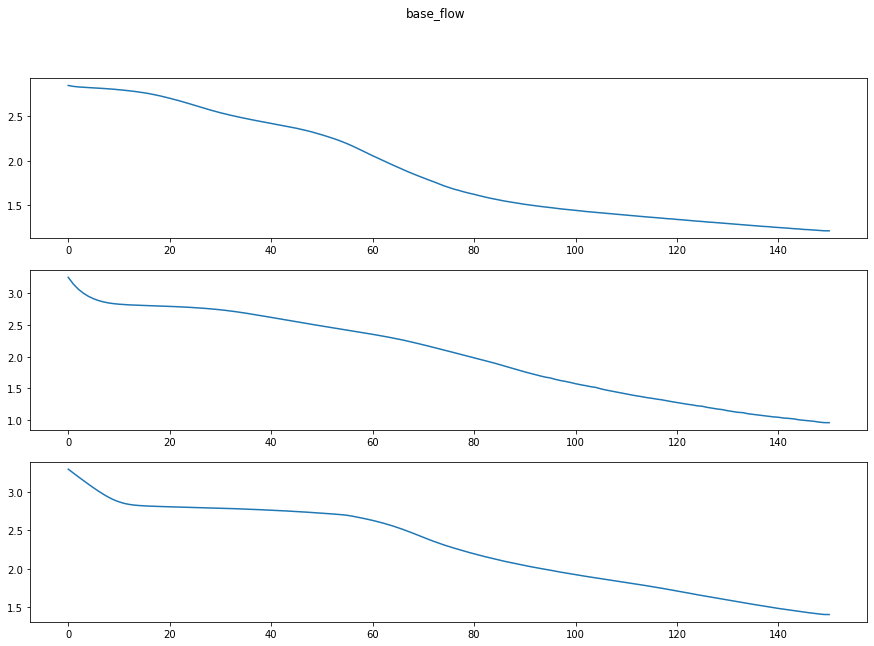

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full1")
flow_type = 'base_flow'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/baseflow_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

### Large dataset size

In [0]:
data_size = 9000

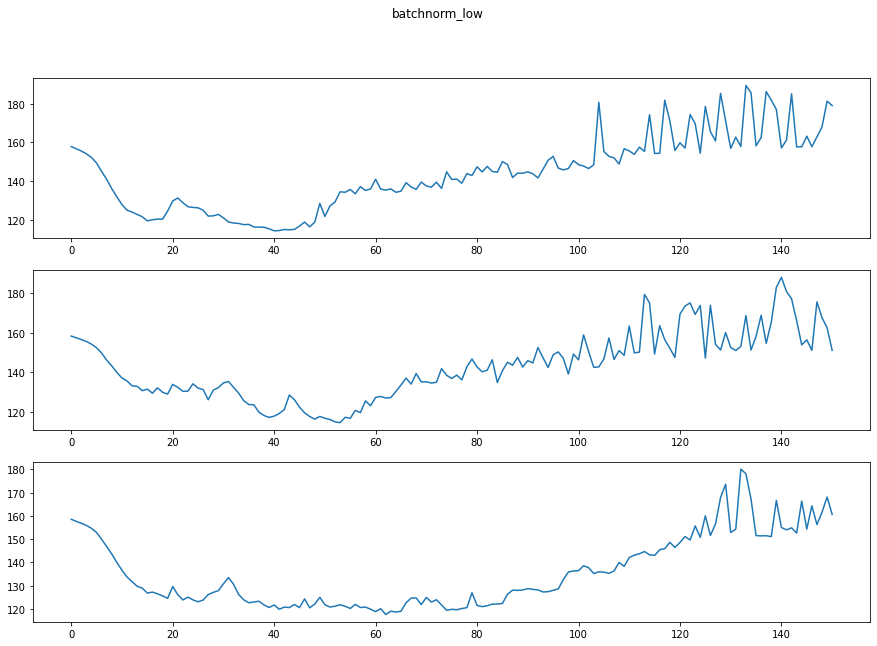

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full1")
flow_type = 'batchnorm_low'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/{flow_type}_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

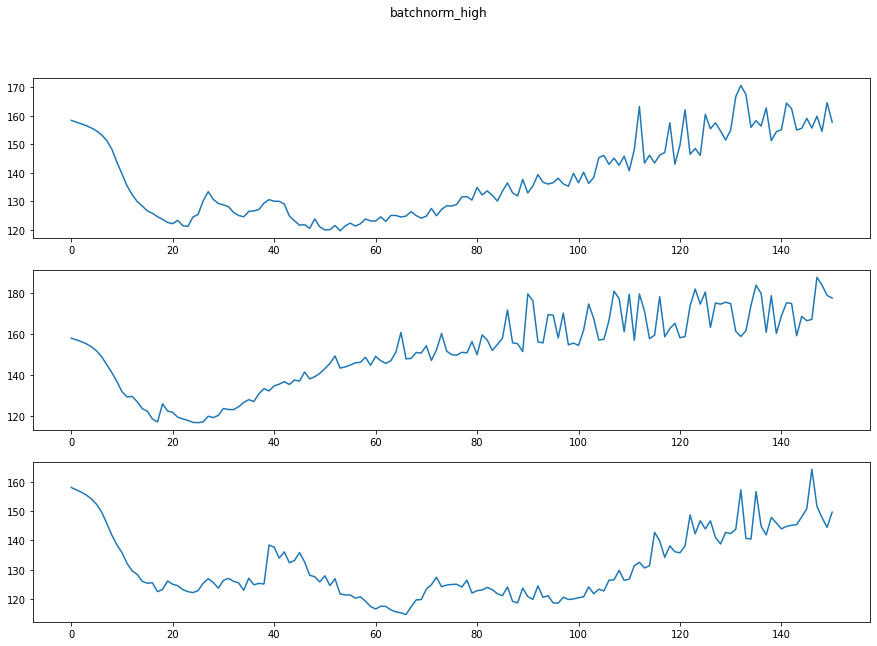

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full1")
flow_type = 'batchnorm_high'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/{flow_type}_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

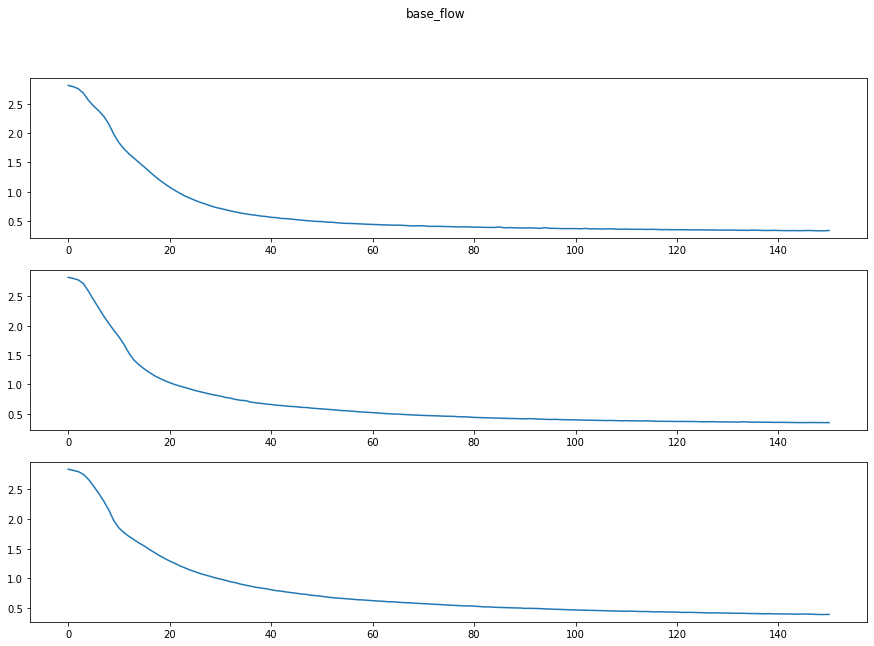

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full1")
flow_type = 'base_flow'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/baseflow_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

So for small dataset sizes the shape of the training logs seems very simillar - however the batchnorm flows are just a factor 80 worse. And we can even see that one of the training runs with highmomentum batchnorm glitched out.

The picture gets even worse for batchnorm with a larger dataset size. Here all of the training runs glitches out

## 2000 batchsize

### Small dataset size

In [0]:
data_size = 1000

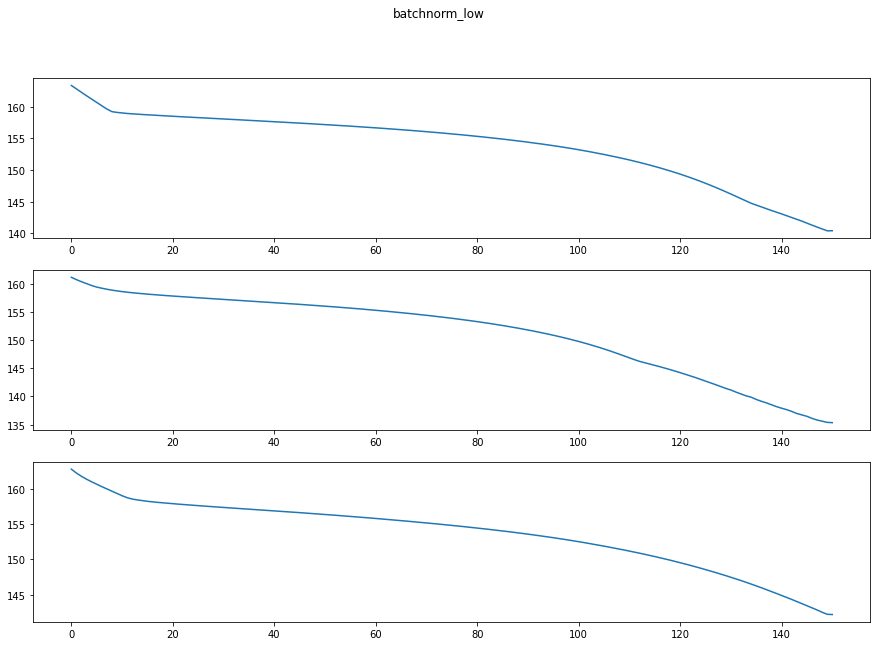

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full2_high_bs")
flow_type = 'batchnorm_low'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/{flow_type}_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

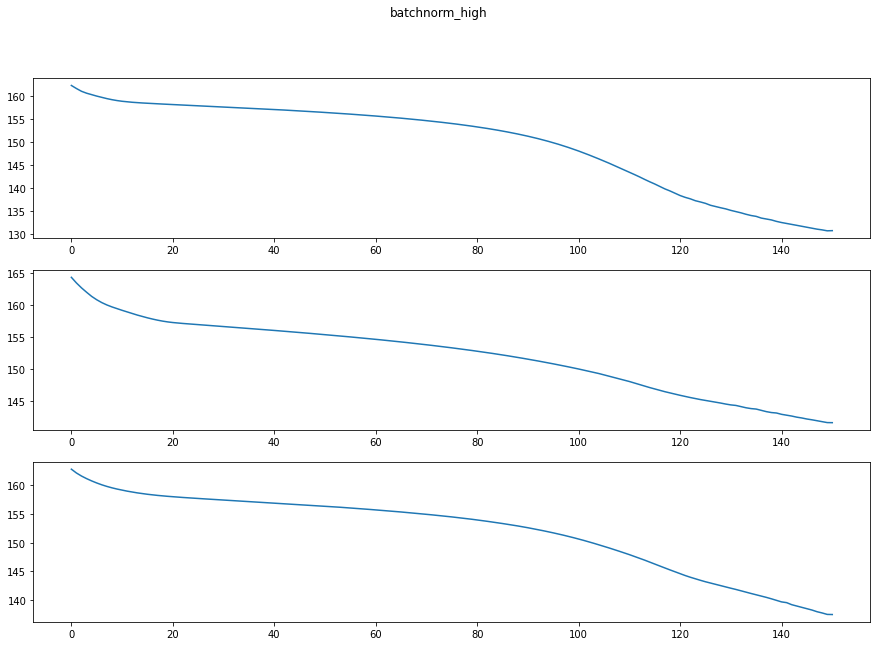

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full2_high_bs")
flow_type = 'batchnorm_high'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/{flow_type}_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

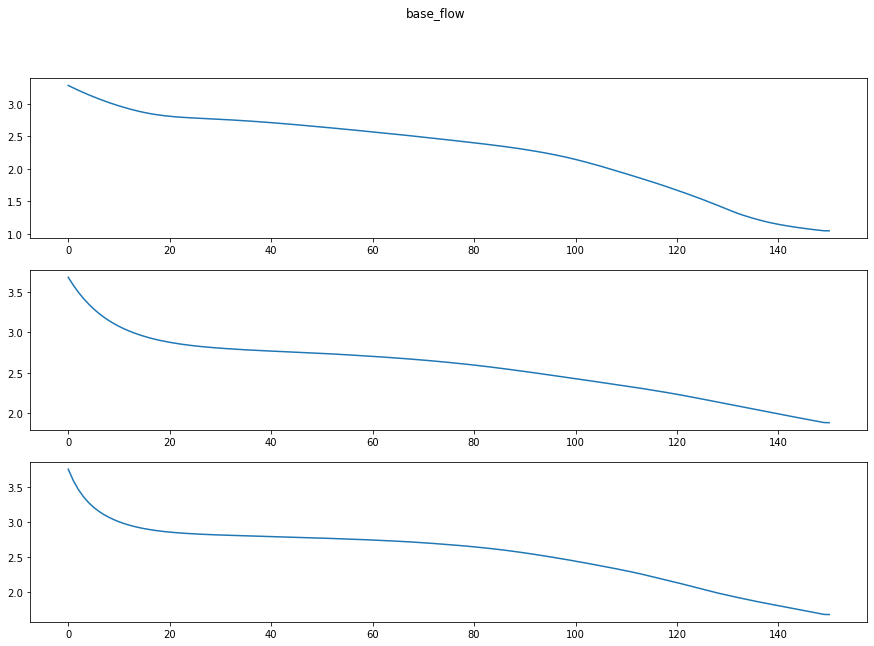

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full2_high_bs")
flow_type = 'base_flow'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/baseflow_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

### Large dataset size

In [0]:
data_size = 9000

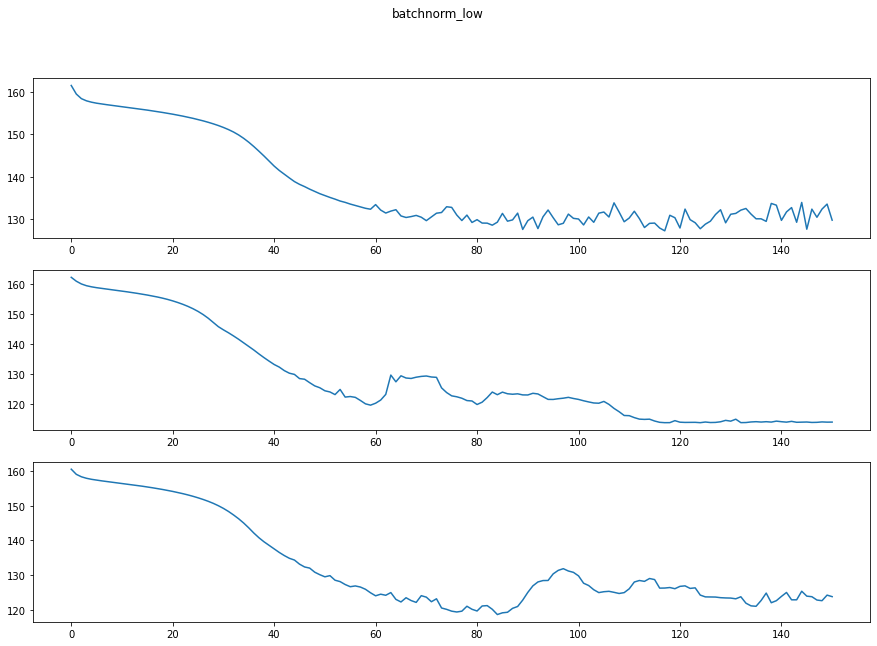

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full2_high_bs")
flow_type = 'batchnorm_low'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/{flow_type}_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

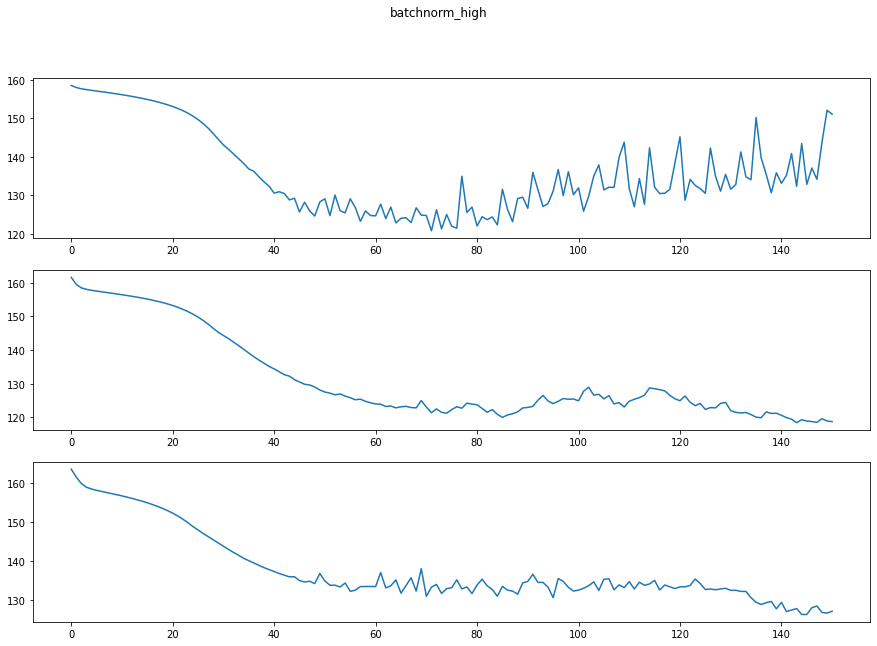

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full2_high_bs")
flow_type = 'batchnorm_high'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/{flow_type}_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

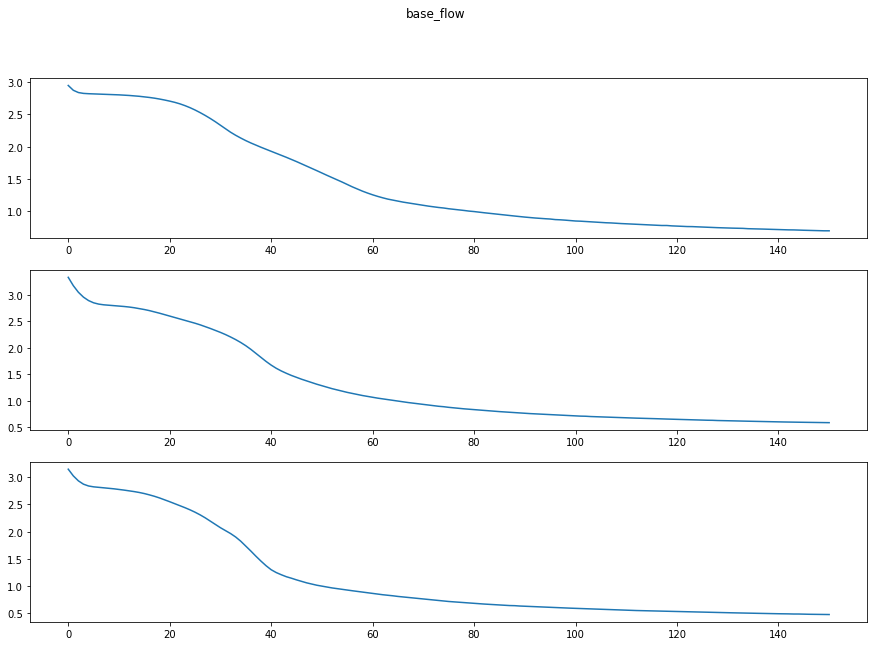

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full2_high_bs")
flow_type = 'base_flow'
fig, axs = plt.subplots(3, figsize=(15,10))
fig.suptitle(flow_type)
for i in range(1,4):
    file_path = f'{base_path}/run{i}/{flow_type}/baseflow_{data_size}.pickle'

    with open(file_path, 'rb') as f:
        loaded_dict = pickle.load(f)

    axs[i-1].plot(loaded_dict['logs']['train'])

So for the large batch size we have almost exactly the same picture it just seems that the batchnormalization "survives" longer before glitching out. Especially the low momentum seems to be close to working - even though the achieved loss is still a factor 80 worse. 

# Test of numerical stability of Batchnorm
On possible reason for the weird behaviour of flows with batchnorm could be that the normalization makes the flows numerical unstable.

I have tested arond a bit and I have found that the way gamma is initialized seems a bit weird.

The implementation http://docs.pyro.ai/en/stable/_modules/pyro/distributions/transforms/batchnorm.html#BatchNorm always multiplies the scaling with a "constrained gamma" where epsilon is added for numerical stability. However as gamma is initialized as 0 this means that all data send through the batchnorm gets scaled by 1e-6.

## Test on coordinate data
Here I just use coordinate data as this is the data I will use it on later anyway. However the problem is not the data - see the gaussian example later

In [0]:
from torch.nn import ModuleList
import torch
from pyro.distributions.transforms import batchnorm
import os
torch.set_printoptions(edgeitems=10)

In [0]:
donkey_folder = os.path.join(dataset_folder, 'Donkey_republic')
csv_path = os.path.join(donkey_folder, 'CoordinateSearchlog2.csv')
donkey_df = pd.read_csv(csv_path, parse_dates=[4, 11])
obs_cols = ['user_location_latitude', 'user_location_longitude']
xy_data = donkey_df.loc[:,obs_cols].values[:10]

In [0]:
normal_dist = pyro.distributions.Normal(10*torch.ones(1), 3*torch.ones(1))

In [0]:
test_data = normal_dist.sample((5,))

In [0]:
#test_data = torch.tensor(xy_data)
print(test_data)

# So the data is as we expect and all the variance is around 1e-2.

tensor([[12.5053],
        [11.6021],
        [13.0646],
        [ 7.7704],
        [14.0563]])


In [0]:
test_data.std()

tensor(2.4220)

In [0]:
bn = batchnorm(1, momentum=1)
#bn.gamma.data += torch.ones(2)
modulelist = ModuleList(bn.modules())
modulelist.train()
transformed = bn._inverse(test_data)
transformed

tensor([[ 2.9132e-07],
        [-8.1604e-08],
        [ 5.2224e-07],
        [-1.6636e-06],
        [ 9.3168e-07]], grad_fn=<AddBackward0>)

In [0]:
transformed.std()

tensor(1.0000e-06, grad_fn=<StdBackward0>)

In [0]:
bn(transformed)
# We can however get back to the initial data.

tensor([[12.5053],
        [11.6021],
        [13.0646],
        [ 7.7704],
        [14.0563]], grad_fn=<AddBackward0>)

So the batchnormalization reduces the scale of the data with around 1e-6. When we link these in a flow this could definetly be a problem.

## Linking multiple batchnorms

In [0]:
test_data

tensor([[12.5053],
        [11.6021],
        [13.0646],
        [ 7.7704],
        [14.0563]])

In [0]:
depth = 10
bn_arr = [batchnorm(1, momentum=0.1) for _ in range(depth)]
#bn.gamma.data += torch.ones(2)
modulelist = ModuleList(bn_arr)
modulelist.train()

transformed = test_data
for i in range(depth):
    transformed = bn_arr[i]._inverse(transformed)

transformed

tensor([[ 9.2127e-39],
        [-2.5803e-39],
        [ 1.6515e-38],
        [-5.2609e-38],
        [ 2.9462e-38]], grad_fn=<AddBackward0>)

In [0]:
reverse_data = transformed
for i in range(depth):
    reverse_data = bn_arr[i](reverse_data)

reverse_data

tensor([[inf],
        [inf],
        [inf],
        [inf],
        [inf]], grad_fn=<AddBackward0>)

## Test with changed Gamma
If we initialize the gamma as 1 instead of 0 it seems like we get a batchnormalization behaving more like we would expect

In [0]:
depth = 10
bn_arr = [batchnorm(1, momentum=0.1) for _ in range(depth)]

for i in range(depth):
    bn_arr[i].gamma.data += torch.ones(1)

modulelist = ModuleList(bn_arr)
modulelist.train()

transformed = test_data
for i in range(depth):
    transformed = bn_arr[i]._inverse(transformed)

transformed

tensor([[ 0.2913],
        [-0.0816],
        [ 0.5222],
        [-1.6636],
        [ 0.9317]], grad_fn=<AddBackward0>)

In [0]:
transformed.std()

tensor(1.0000, grad_fn=<StdBackward0>)

In [0]:
reverse_data = transformed
for i in range(depth):
    reverse_data = bn_arr[i](reverse_data)

reverse_data

tensor([[ 1.5352],
        [ 1.0805],
        [ 1.8168],
        [-0.8485],
        [ 2.3160]], grad_fn=<AddBackward0>)

So if the gamma is not 0 batchnormalization behaves much more like we would expect. 

# Test on random data
Since this problem is with the implementation this is also a problem for data with larger variance than the coordinate data.

Here is an example with gaussian noise.

Batchnorm test

In [0]:
normal_dist = pyro.distributions.Normal(0,1)
random_data = normal_dist.sample((xy_data.shape))
random_data

tensor([[ 1.1012,  0.3552],
        [ 0.0596, -1.6812],
        [ 0.7103,  1.2627],
        [-1.9932,  0.5127],
        [ 0.3376, -1.1047],
        [-0.4281, -0.2121],
        [-1.2143,  0.6542],
        [ 0.1954,  0.7298],
        [ 0.2504, -0.3849],
        [-1.4414, -0.3281]])

In [0]:
bn = batchnorm(2, momentum = 1, epsilon=1e-5)
transformed = bn._inverse(random_data)
transformed

tensor([[ 1.3392e-06,  4.1653e-07],
        [ 3.0094e-07, -1.8464e-06],
        [ 9.4949e-07,  1.4250e-06],
        [-1.7454e-06,  5.9162e-07],
        [ 5.7806e-07, -1.2058e-06],
        [-1.8530e-07, -2.1382e-07],
        [-9.6901e-07,  7.4883e-07],
        [ 4.3628e-07,  8.3281e-07],
        [ 4.9107e-07, -4.0592e-07],
        [-1.1953e-06, -3.4282e-07]], grad_fn=<AddBackward0>)

In [0]:
bn(transformed)

tensor([[ 1.1012,  0.3552],
        [ 0.0596, -1.6812],
        [ 0.7103,  1.2627],
        [-1.9932,  0.5127],
        [ 0.3377, -1.1047],
        [-0.4281, -0.2121],
        [-1.2143,  0.6542],
        [ 0.1954,  0.7298],
        [ 0.2504, -0.3849],
        [-1.4414, -0.3281]], grad_fn=<AddBackward0>)

# Batchnorm of trained flow
The above gamma problem would not be a problem if the training of the flow fixes the gamma to a proper value during training.
However the batchnorms of a trained flow does not learn a proper gamma.
Hence the normalization have a bad variance scaling at best and could even introduce numerically instability to the training.
The batchnorm parameters are added to the flows modules like mentioned here: https://github.com/pyro-ppl/pyro/issues/1517, they show up in the module list like expected and the beta does learn non-zero values.

I have no idea why we do not learn a proper gamma value

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full2_high_bs")

file_path = f'{base_path}/run1/batchnorm_low/batchnorm_low_8000.pickle'

with open(file_path, 'rb') as f:
    loaded_dict = pickle.load(f)



In [0]:
loaded_dict['model'].modules

ModuleList(
  (0): ConditionalAffineCoupling2(
    (hypernet): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=6, out_features=18, bias=True)
        (1): Linear(in_features=18, out_features=18, bias=True)
        (2): Linear(in_features=18, out_features=2, bias=True)
      )
      (f): ReLU()
    )
  )
  (1): ConditionalAffineCoupling2(
    (hypernet): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=6, out_features=18, bias=True)
        (1): Linear(in_features=18, out_features=18, bias=True)
        (2): Linear(in_features=18, out_features=2, bias=True)
      )
      (f): ReLU()
    )
  )
  (2): ConditionalAffineCoupling2(
    (hypernet): DenseNN(
      (layers): ModuleList(
        (0): Linear(in_features=6, out_features=18, bias=True)
        (1): Linear(in_features=18, out_features=18, bias=True)
        (2): Linear(in_features=18, out_features=2, bias=True)
      )
      (f): ReLU()
    )
  )
  (3): ConditionalAffineCoupling2(
    (hypern

In [0]:
for i in range(11,21):
    print(loaded_dict['model'].modules[i].gamma)

Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)


In [0]:
for i in range(11,21):
    print(loaded_dict['model'].modules[i].beta)

# Note that the first batchnorm is not used in the flow but removed since we use sklearn to normalize the data before training.
# A cleaned implementation would remove it from the module list

Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0014, -0.8358], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.0129, 0.1718], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0734, -0.2568], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0117,  0.2473], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.1313, -0.4508], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0711,  0.2196], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 7.3096e-05, -2.0394e-01], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0789, -0.4372], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0011, -0.2632], device='cuda:0', requires_grad=True)


# Fixed Gamma value test

In [0]:
base_path = os.path.join(root_path, "results/two_moons/unreg_run_full3_gamma_fix")

results_dict = {}

folders = os.listdir(base_path)
for run_name in folders:
    run_path = folder = os.path.join(base_path, run_name)
    reg_names = os.listdir(run_path)
    results_dict[run_name] = {}
    for reg_name in reg_names:
        reg_path = os.path.join(run_path, reg_name)
        file_names = os.listdir(reg_path)
        results_dict[run_name][reg_name] = {}
        for file_name in file_names:
            data_size = int(file_name.split('_')[-1].split('.')[0])
            file = os.path.join(reg_path, file_name)
            with open(file, 'rb') as f:
                loaded_dict = pickle.load(f)
            results_dict[run_name][reg_name][data_size] = loaded_dict['logs']['test'][-1]

runs = list(results_dict.keys())
#runs = ['unreg_comparison_full1', 'unreg_comparison_full2']
regs = list(results_dict[runs[0]].keys())
#regs = ['sqrt', 'l2', 'constant', 'rot']
data_sizes = np.sort(list(results_dict[runs[0]][regs[0]].keys()))

plot_arrays = {}
for reg in regs:
    reg_mean_array = []
    reg_std_array = []
    plot_arrays[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_std_array.append(np.std(runs_array))
    plot_arrays[reg]['mean'] = reg_mean_array
    plot_arrays[reg]['std'] = reg_std_array

plt.figure(figsize=(15,10))
plt.ylim(-3.5, 0)
#regs = ['batchnorm_and_clipped_adam']
#regs = ['base_flow']
#regs = ['batchnorm']
#regs = ['clipped_adam']
for reg in regs:
    mean = -np.array(plot_arrays[reg]['mean'])
    std = np.array(plot_arrays[reg]['std'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, mean + std, mean - std, alpha=0.1)

plt.xscale('log')
plt.legend(regs, loc='upper left', fontsize=15, markerscale=4)
plt.title('1500 epochs and 500 batchsize ', fontsize=15)
plt.xlabel('Number of datapoints', fontsize=15)
plt.ylabel('Log Likelihood')
plt.show();

In [0]:
plot_arrays = {}
for reg in regs:
    reg_mean_array = []
    reg_max_array = []
    reg_min_array = []
    plot_arrays[reg] = {}
    for data_size in data_sizes:
        runs_array = []
        for run in runs:
            runs_array.append(results_dict[run][reg][data_size])
        reg_mean_array.append(np.mean(runs_array))
        reg_max_array.append(np.max(runs_array))
        reg_min_array.append(np.min(runs_array))
    plot_arrays[reg]['mean'] = reg_mean_array
    plot_arrays[reg]['max'] = reg_max_array
    plot_arrays[reg]['min'] = reg_min_array


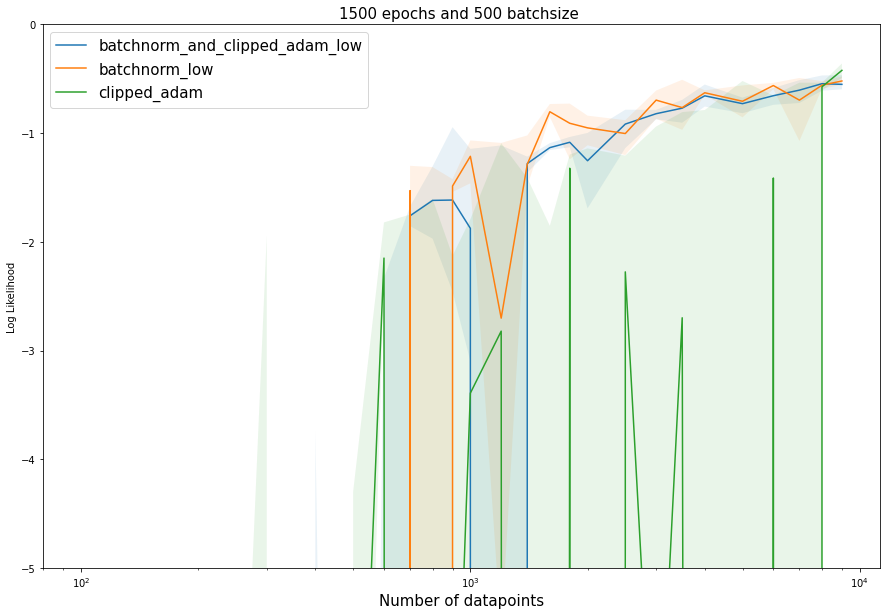

In [0]:
plt.figure(figsize=(15,10))
plt.ylim(-5, 0)
#regs = ['batchnorm_and_clipped_adam']
#regs = ['base_flow']
#regs = ['batchnorm']
#regs = ['clipped_adam']
for reg in regs:
    mean = -np.array(plot_arrays[reg]['mean'])
    max_val = -np.array(plot_arrays[reg]['max'])
    min_val = -np.array(plot_arrays[reg]['min'])
    plt.plot(data_sizes, mean)
    plt.fill_between(data_sizes, max_val, min_val, alpha=0.1)

plt.xscale('log')
plt.legend(regs, loc='upper left', fontsize=15, markerscale=4)
plt.title('1500 epochs and 500 batchsize ', fontsize=15)
plt.xlabel('Number of datapoints', fontsize=15)
plt.ylabel('Log Likelihood')
plt.show();

In [0]:
file_path = f'{root_path}/results/two_moons/unreg_run_full3_gamma_fix/run1/batchnorm_and_clipped_adam_low/batchnormclippedadam_low_9000.pickle'

In [0]:
with open(file_path, 'rb') as f:
    loaded_dict = pickle.load(f)

In [0]:
loaded_dict['settings']

{'batch_size': 500,
 'batchnorm_momentum': 0.1,
 'c_net_depth': 2,
 'c_net_h_dim': 18,
 'clipped_adam': 10.0,
 'context_dropout': None,
 'context_n_depth': 2,
 'context_n_h_dim': 10,
 'coupling_dropout': None,
 'data_size': 9000,
 'epochs': 1500,
 'flow_depth': 10,
 'l2_reg': None,
 'problem_dim': 2,
 'rich_context_dim': 5}

In [0]:
loaded_dict['model'].modules[12].gamma

Parameter containing:
tensor([0.8751, 1.0008], device='cuda:0', requires_grad=True)

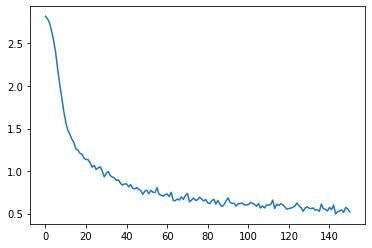

In [0]:
plt.plot(loaded_dict['logs']['train'])

#### So with the initialization at 1 it seems that the batchnormalization works really well but the gamma value is still not learning correctly 